In [78]:
import numpy as np
import scipy.misc
import scipy.ndimage
import matplotlib.pyplot as plt
import cv2
import time
from numba import jit
from PIL import Image
import imageio

Show inputs


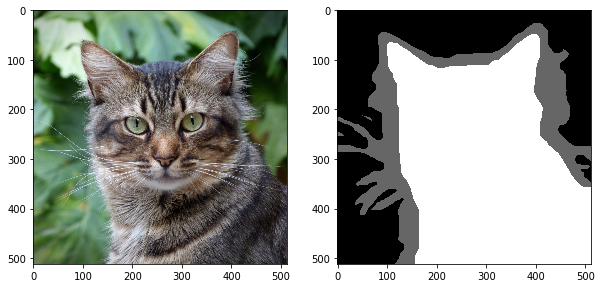

In [155]:
orig = imageio.imread('cat.png')
gray = imageio.imread('cat.png',as_gray='True')
tri = imageio.imread('cat_trimap.png',as_gray = 'True')
h,w = gray.shape
print("Show inputs")
fig = plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(orig)
plt.subplot(122)
plt.imshow(tri,cmap='gray')
plt.show()

Show fg and bg and mid


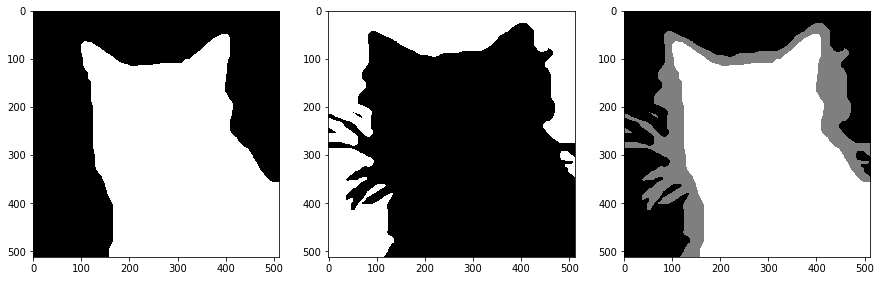

In [156]:
fg = tri == 255
bg = tri == 0
mid = np.zeros(tri.shape)
for i in range(mid.shape[0]):
    for j in range(mid.shape[1]):
        if(tri[i,j] != 0 and tri[i,j] != 255):
            mid[i,j] = 127
        if(tri[i,j] != 0 and tri[i,j] > 200):
            mid[i,j] = 255

print("Show fg and bg and mid")
fig = plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(fg,cmap='gray')
plt.subplot(132)
plt.imshow(bg,cmap='gray')
plt.subplot(133)
plt.imshow(mid,cmap='gray')
plt.show()

Show fg and bg and mid


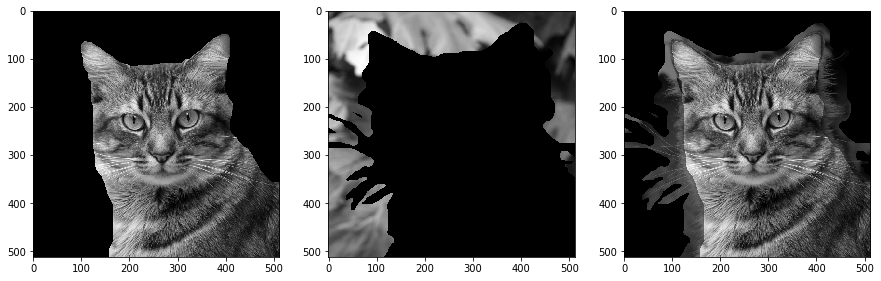

In [157]:
gray_fg = gray * fg
gray_bg = gray * bg
non_bg = gray * mid

print("Show fg and bg and mid")
fig = plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(gray_fg,cmap='gray')
plt.subplot(132)
plt.imshow(gray_bg,cmap='gray')
plt.subplot(133)
plt.imshow(non_bg,cmap='gray')
plt.show()

Generation of an estimate alpha matte 

First, the unknown region (not fg or bg) is found 

Then ,the pixels belonging to the unknown region is multiplied with an intensity of 0.5 and added to the fg to get an estimate alpha matte 

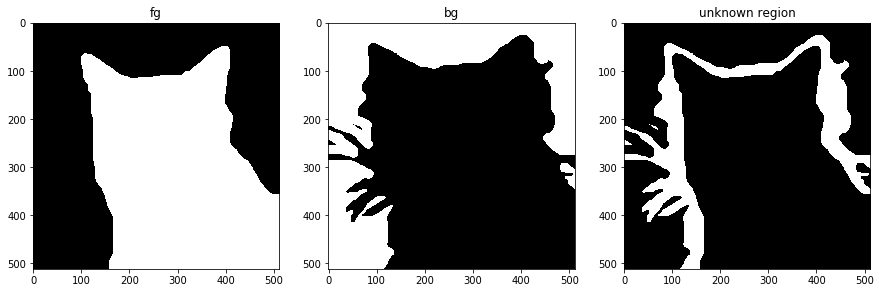

In [158]:
unknown = True ^ np.logical_or(fg,bg)

fig = plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(fg,'gray')
plt.title('fg')
plt.subplot(132)
plt.imshow(bg,'gray')
plt.title('bg')
plt.subplot(133)
plt.imshow(unknown,'gray')
plt.title('unknown region')
plt.show()


(512, 512)


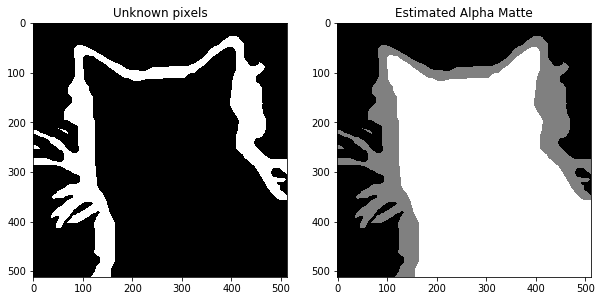

In [159]:
Estimate_alpha = fg + 0.5 * unknown
print(Estimate_alpha.shape)
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(unknown,'gray')
plt.title('Unknown pixels')
plt.subplot(122)
plt.imshow(Estimate_alpha,'gray')
plt.title('Estimated Alpha Matte')
plt.show()

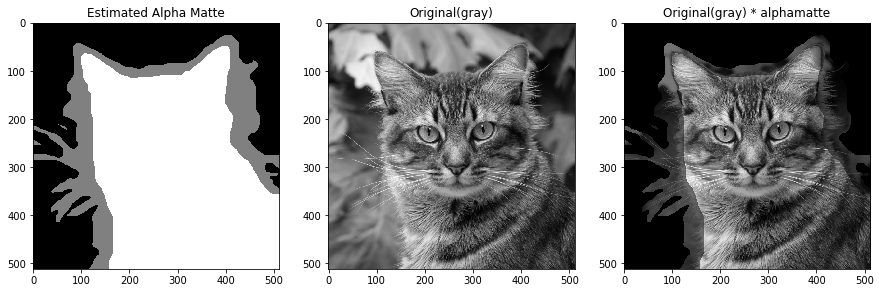

In [160]:
non_bg = gray * Estimate_alpha

plt.figure(figsize=(15,15))
plt.subplot(133)
plt.imshow(non_bg,'gray')
plt.title('Original(gray) * alphamatte')
plt.subplot(131)
plt.imshow(Estimate_alpha,'gray')
plt.title('Estimated Alpha Matte')
plt.subplot(132)
plt.imshow(gray,'gray')
plt.title('Original(gray)')

plt.show()

Generating Approximate Background and Foreground in the unknown region by checking the nearest neighbouring pixels

In [161]:
not_fg = np.logical_not(fg)
bg_approx = cv2.inpaint(gray_bg.astype(np.uint8),(unknown + fg ).astype(np.uint8)*255,3,cv2.INPAINT_TELEA)*not_fg
bg_approx = bg_approx.astype(np.float32)
not_bg = np.logical_not(bg)
fg_approx = cv2.inpaint(gray_fg.astype(np.uint8),(unknown + bg ).astype(np.uint8)*255,3,cv2.INPAINT_TELEA)*not_bg
fg_approx = fg_approx.astype(np.float32)

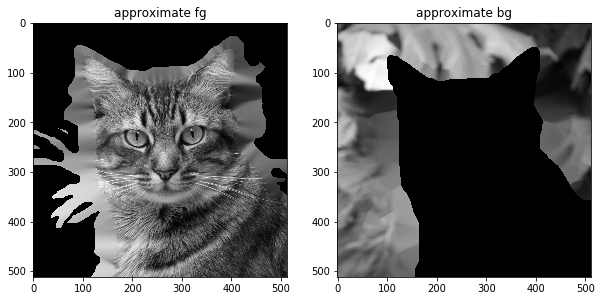

In [162]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(fg_approx,'gray')
plt.title('approximate fg')
plt.subplot(122)
plt.imshow(bg_approx,'gray')
plt.title('approximate bg')
plt.show()

Using Poisson Equations, Reconstructing the Alpha matte

We use the gradient field of alpha matte to estimate the alpha matte

Finding the approximate matte gradient field

$$\Delta \alpha = div \frac{\nabla I}{F-B}$$

First, we find the approximate F-B 

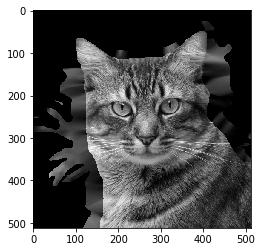

In [163]:
diff_approx = fg_approx - bg_approx
diff_new = np.maximum(diff_approx,0)
diff_new = np.minimum(diff_new,255)

plt.imshow(diff_new, cmap='gray')
plt.show()


Modifying the approximate F-B

F-B where F and B are approximate foreground and background images


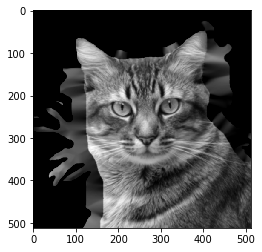

In [164]:
diff_approx = scipy.ndimage.filters.gaussian_filter(diff_approx, 0.9)
diff_new = np.maximum(diff_approx,0)
diff_new = np.minimum(diff_new,255)

print("F-B where F and B are approximate foreground and background images")
plt.imshow(diff_new, cmap='gray')
plt.show()

Then, we find the approximate gradient matte using the divergence operator

In [165]:
dy, dx = np.gradient(gray)
d2y, _ = np.gradient(dy/diff_approx)
_, d2x = np.gradient(dx/diff_approx)

b = d2y + d2x

Reconstructing alpha matte using the approximate gradient field(b) and Estimated alpha matte

We find the alpha matte by solving the laplacian

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/9ae5cade73b31dee0e04eb21b1e6e13b5944ef41)

We use the Gauss-Seidel iteration for this
![ig](https://wikimedia.org/api/rest_v1/media/math/render/svg/02f26444f4da61ae84a9824a6b5292949a483fcc)

In [166]:
def Alpha_matte_slow(alpha, b):
    new_alpha = alpha.copy()
    old_alpha = np.zeros(new_alpha.shape)
    
    threshold = 0.1
    max_iterations = 50
    
    iterations = 1
    change = np.sum(np.abs(new_alpha - old_alpha))
    while (iterations < max_iterations and change > threshold):
        old_alpha = new_alpha.copy()
        for i in range(1, h-1):
            for j in range(1, w-1):
                if(unknown[i,j]):
                    new_alpha[i,j] = 1/4  * (new_alpha[i-1 ,j] + new_alpha[i,j-1] + old_alpha[i, j+1] + old_alpha[i+1,j] - b[i,j])
        iterations = iterations + 1
        change = np.sum(np.abs(new_alpha - old_alpha))
    return new_alpha

In [167]:
New_alpha_slow = Alpha_matte_slow(Estimate_alpha, b)

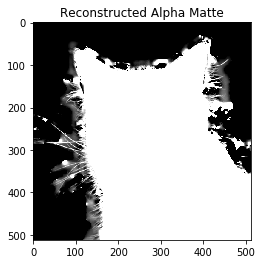

In [168]:
New_alpha_slow = np.maximum(New_alpha_slow,0)
New_alpha_slow = np.minimum(New_alpha_slow,1)
New_alpha_slow = New_alpha_slow.reshape(h,w)

plt.imshow(New_alpha_slow, cmap='gray')
plt.title("Reconstructed Alpha Matte")
plt.show()

# Using an optimised method to find Alpha matte 

In [169]:
def opt_Alpha_matte_jit(alpha,b,unknown_seg):
    new_alpha = alpha.copy()
    old_alpha = np.zeros(new_alpha.shape)
    
    threshold = 0.1
    max_iterations = 50
    
    iterations = 1
    non_zero = np.nonzero(unknown_seg)
#     print(unknown_seg.shape)
    ca = np.transpose(non_zero)
    c = ca[(ca[:,0]>=1)&(ca[:,0]<h-1)&(ca[:,1]>=1)&(ca[:,1]<w-1)]
    c0 = c[:,0]
    c1 = c[:,1]
    change = np.sum(np.abs(new_alpha - old_alpha))
    while (iterations < max_iterations and change > threshold):
        old_alpha = new_alpha.copy()
        new_alpha[c0,c1] = 1/4  * (new_alpha[c0-1 ,c1] + new_alpha[c0,c1-1] + old_alpha[c0, c1+1] + old_alpha[c0+1,c1] - b[c0,c1])
        iterations = iterations + 1
        change = np.sum(np.abs(new_alpha - old_alpha))
    return new_alpha        
    

Comparing the time difference between optimised and slow version 

In [170]:
%timeit Alpha_matte_slow(Estimate_alpha, b)
%timeit opt_Alpha_matte_jit(Estimate_alpha, b)

KeyboardInterrupt: 

## Generating final image using chroma-keying

In [171]:
New_alpha = opt_Alpha_matte_jit(Estimate_alpha, b,unknown)
New_alpha = np.maximum(New_alpha,0)
New_alpha = np.minimum(New_alpha,1)
New_alpha = New_alpha.reshape(h,w)
# New_alpha = New_alpha_slow

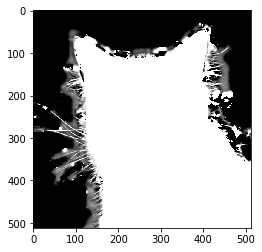

In [172]:
plt.imshow(New_alpha, cmap='gray')
plt.show()

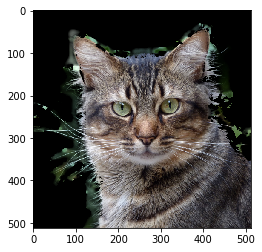

In [173]:
new_fg = (New_alpha.reshape(h,w,1).repeat(3,2)*orig).astype(np.uint8)
plt.imshow(new_fg,cmap='gray')
bg = imageio.imread('bg.jpg')
bg = np.asarray(bg)
res = np.zeros(new_fg.shape)
# print(res.shape)
# print(bg.shape)

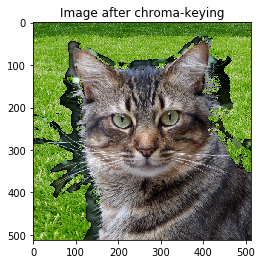

In [174]:
new_fg_arr = np.asarray(new_fg)
# print(new_fg_arr.shape)
# print(new_fg_arr[200,250] == [0,0,0])
for i in range(new_fg.shape[0]):
    for j in range(new_fg.shape[1]):
        if(i<new_fg_arr.shape[0] and j<new_fg_arr.shape[1]):
            if(new_fg_arr[i,j,0] == 0 and new_fg_arr[i,j,1] == 0 and new_fg_arr[i,j,2] == 0):
                res[i,j,0] = bg[i,j,0]
                res[i,j,1] = bg[i,j,1]
                res[i,j,2] = bg[i,j,2]
            else:
                res[i,j,0] = new_fg_arr[i,j,0]
                res[i,j,1] = new_fg_arr[i,j,1]
                res[i,j,2] = new_fg_arr[i,j,2]
        else:
            res[i,j,0] = bg[i,j,0]
            res[i,j,1] = bg[i,j,1]
            res[i,j,2] = bg[i,j,2]
            
res = res.astype(np.uint8)
res_image = Image.fromarray(res)
plt.imshow(res)
plt.title('Image after chroma-keying')
plt.show()

# Generating Final Image using Alpha Blending

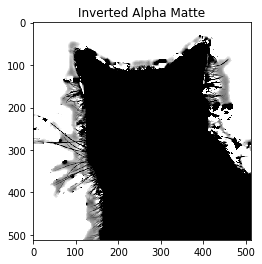

In [175]:
inverted_alpha = 1 - New_alpha

plt.imshow(inverted_alpha, cmap='gray')
plt.title("Inverted Alpha Matte")
plt.show()

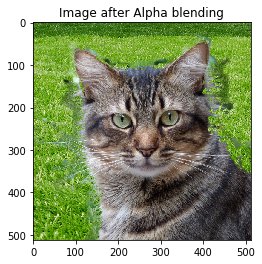

In [176]:
bg_new = imageio.imread('bg.jpg')
bg_new = bg_new[0:h, 0:w, :]
final = np.zeros(bg_new.shape)

final[:, :, 0] = New_alpha * orig[:, :, 0] + inverted_alpha * bg_new[:, :, 0] 
final[:, :, 1] = New_alpha * orig[:, :, 1] + inverted_alpha * bg_new[:, :, 1] 
final[:, :, 2] = New_alpha * orig[:, :, 2] + inverted_alpha * bg_new[:, :, 2] 

plt.imshow(final/255)
plt.title("Image after Alpha blending")
plt.show()

## Local Poisson Matting

(512, 512)


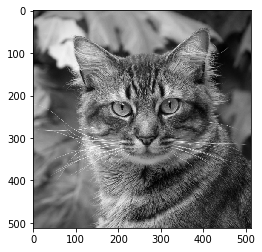

In [177]:
plt.imshow(gray,cmap='gray')
print(gray.shape)

In [194]:
i_coord = 0
j_coord = 0
local_matte = np.zeros_like(gray)
im_w,im_h = gray.shape
grid_size = 100


for i_coord in range(0,im_w,grid_size):
    for j_coord in range(0,im_h,grid_size):
        
        if(im_w - i_coord >= grid_size and im_h - j_coord >= grid_size):
            addi = grid_size
            addj = grid_size
                
        
        elif(im_w - i_coord < grid_size and im_h - j_coord>grid_size ):
            addi = im_w - i_coord -1
            addj = grid_size
        
        
        elif(im_w - i_coord >grid_size and im_h - j_coord < grid_size):
            addi = grid_size
            addj = im_h - j_coord-1
        
        elif(im_w - i_coord < grid_size and im_h - j_coord <grid_size):
            addi = im_w - i_coord -1
            addj = im_h - j_coord-1
            
            
        diff_approx2 = diff_approx[i_coord:i_coord+addi,j_coord:j_coord+addj]
        diff_approx2 = scipy.ndimage.filters.gaussian_filter(diff_approx2, 0.9)
        
        diff_approx20 = diff_approx[i_coord:i_coord+addi+1,j_coord:j_coord+addj+1]
        diff_approx20 = scipy.ndimage.filters.gaussian_filter(diff_approx20, 0.9)
        
        
        seg1 = gray[i_coord:i_coord+addi+1,j_coord:j_coord+addj+1]
        
        fg_approx_seg = fg_approx[i_coord:i_coord+addi+1,j_coord:j_coord+addj+1]
        bg_approx_seg = bg_approx[i_coord:i_coord+addi+1,j_coord:j_coord+addj+1]
        
        dyfg, dxfg = np.gradient(fg_approx_seg)
        d2yfg, _ = np.gradient(dyfg/diff_approx20)
        _, d2xfg = np.gradient(dxfg/diff_approx20)
        
        dybg, dxbg = np.gradient(bg_approx_seg)
        d2ybg, _ = np.gradient(dybg/diff_approx20)
        _, d2xbg = np.gradient(dxbg/diff_approx20)
        
        
        dy, dx = np.gradient(seg1)
        d2y, _ = np.gradient(dy/diff_approx20)
        _, d2x = np.gradient(dx/diff_approx20)
        
        
       
        
        
        
        unknown_seg = unknown[i_coord:i_coord+addi,j_coord:j_coord+addj]
        Estimate_alpha_seg = Estimate_alpha[i_coord:i_coord+addi+1,j_coord:j_coord+addj+1]
        inverted_alpha_seg = 1 - Estimate_alpha_seg
        
        b_seg = d2y + d2x -(Estimate_alpha_seg*(d2yfg + d2xfg) + inverted_alpha_seg*(d2ybg+d2xbg))
        
        
        matte = opt_Alpha_matte_jit(Estimate_alpha_seg, b_seg,unknown_seg)
        local_matte[i_coord:i_coord+addi+1,j_coord:j_coord+addj+1] = matte
            
        
        
        


In [195]:
local_matte = np.maximum(local_matte,0)
local_matte = np.minimum(local_matte,1)
local_matte = local_matte.reshape(h,w)

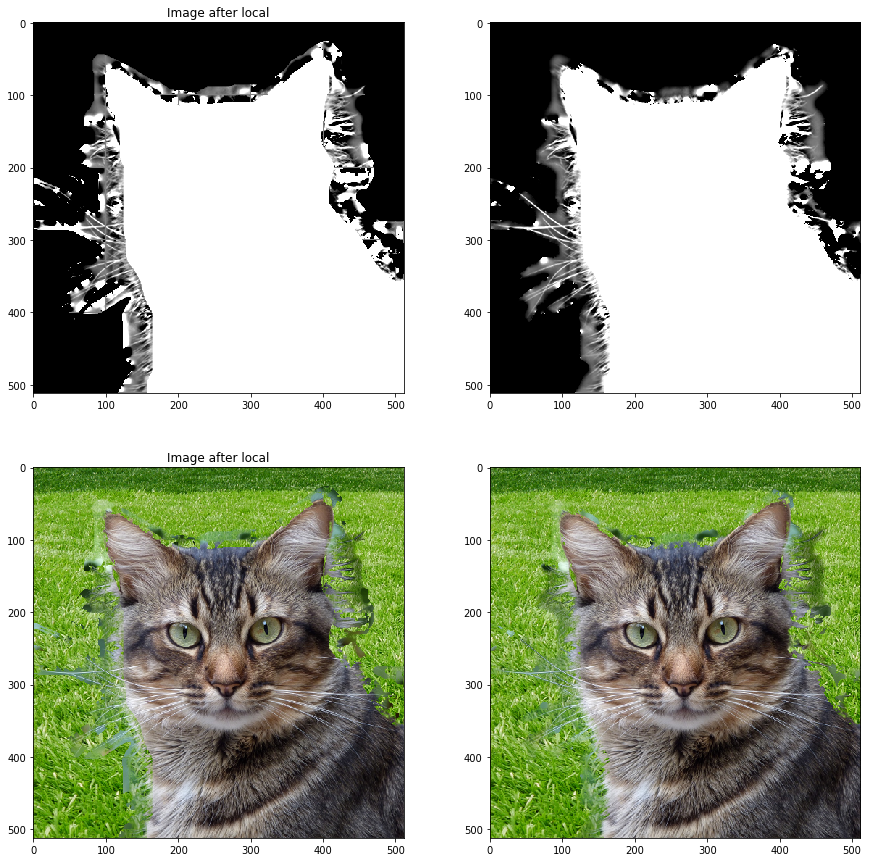

In [196]:
bg_new = imageio.imread('bg.jpg')
bg_new = bg_new[0:h, 0:w, :]
final_seg = np.zeros(bg_new.shape)
inverted_alpha = 1 - local_matte

final_seg[:, :, 0] = local_matte * orig[:, :, 0] + inverted_alpha * bg_new[:, :, 0] 
final_seg[:, :, 1] = local_matte * orig[:, :, 1] + inverted_alpha * bg_new[:, :, 1] 
final_seg[:, :, 2] = local_matte * orig[:, :, 2] + inverted_alpha * bg_new[:, :, 2] 

fig = plt.figure(figsize=(15,15))
plt.subplot(221)
# plt.imshow(final_seg/255)
plt.imshow(local_matte,cmap='gray')
plt.title("Image after local")
plt.subplot(222)
# plt.imshow(final/255)
plt.imshow(New_alpha,cmap='gray')
plt.subplot(223)
plt.imshow(final_seg/255)
# plt.imshow(local_matte,cmap='gray')
plt.title("Image after local")
plt.subplot(224)
plt.imshow(final/255)
# plt.imshow(New_alpha,cmap='gray')
plt.show()